<a href="https://colab.research.google.com/github/NganTran-0017/HIDS/blob/main/ML_HIDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

!rm *.txt
! rm *.int

In [1]:
#@title Specify parameters before running


SZ =  1#@param {type:"number"}         # Indicate a fraction number to sample train set when it's too big. Located in Data Partition

SEQ_WINDOW =  25#@param {type:"integer"} # Indicate the window length to parse the sequence into. Used in Data Parsing section

BATCH_SZ =  32#@param {type:"integer"} # Indicate the window length to parse the sequence into. Used in Data Parsing section

EPOCHS =  2#@param {type:"integer"} # Indicate the window length to parse the sequence into. Used in Data Parsing section

# Indicate to clean data or not. Used in Data Cleaning section
CLEAN = True #@param {type:"boolean"}


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, roc_curve, auc, recall_score, precision_score,plot_confusion_matrix
from sklearn.model_selection import train_test_split
%matplotlib inline

import nltk
nltk.download("popular")

## Tokenizing syscall sequences into n-grams of 6

from nltk.tokenize import word_tokenize
from nltk import ngrams

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

#**Processing data**

Use the given datasets in our GitHub to load the data

In [26]:
  ## Uncomment each line to load Normal data

# Synthetic sendmail csv_file = ['bounce-1.int', 'bounce.int', 'bounce-2.int', 'plus.int', 'queue.int', 'sendmail.daemon.int', 'sendmail.log.int']; DATA = 'Synthetic Sendmail'; DATA_I='Synthetic_Sendmail'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/normal-data/bounce-1.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/normal-data/bounce.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/normal-data/bounce-2.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/normal-data/plus.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/normal-data/queue.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/normal-data/sendmail.daemon.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/normal-data/sendmail.log.int'

# LIVE LPR 
csv_file = ['lpr-normal-10.txt', 'lpr-normal-11.txt']; DATA = 'Live Lpr'; DATA_I='Live-Lpr' 
!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/4.%20Live%20lpr/Normal/real/lpr-normal-11.txt'
!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/4.%20Live%20lpr/Normal/real/lpr-normal-10.txt'

# MIT live lpr csv_file = [ 'mit-lpr-mar.txt']; DATA = 'MIT Live Lpr'; DATA_I='MIT-Lpr' 
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/MIT/mit-lpr-mar.txt'

# LOGIN and PS csv_file = [ 'login-normal.txt', 'ps-normal.txt']; DATA = 'Login and Ps'; DATA_I ="Login-and-Ps"
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/7.Login_and_ps/normal/login-normal.txt'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/7.Login_and_ps/normal/ps-normal.txt'

# INETD csv_file = [ 'inetd-live-unm.int']; DATA = 'Inetd';DATA_I ="Inetd" 
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/8.Inetd/inetd-live-unm.int'

# STIDE csv_file = [ 'stide-normal-500k.txt']; DATA = 'Stide';DATA_I ='Stide' 
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/10.Stide/stide-normal-500k.txt'

# Live Named  csv_file = [ 'normal-named-live-2k.txt']; DATA = 'Live Named';DATA_I ='Live-Named' 
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/6.Live_named/normal-named-live-2k.txt'

# Xlock csv_file = [ 'normal-xlock.txt']; DATA = 'Xlock';DATA_I='Xlock' 
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/5.xlock/normal-xlock.txt'

# Synthetic Ftp 
#csv_file = [ 'nonself1.int','nonself2.int']; DATA = 'Synthetic Ftp'; DATA_I='Synthetic-Ftp'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/2.Synthetic%20Ftp/nonself1.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/2.Synthetic%20Ftp/nonself2.int'

# Synthetic lpr csv_file = ['syn.int']; DATA = 'Synthetic Lpr';DATA_I='Synthetic-Lpr'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/3.Synthetic-lpr/syn.int'

# Concat a list of files into normal df
list_of_dataframes = []
for filename in csv_file:
    list_of_dataframes.append(pd.read_csv(filename, sep=' ', header=None, engine='python'))
df = pd.concat(list_of_dataframes)

# Check number of columns, if > 2, then drop the excess
if len(df.columns) > 2:
    df=df.drop(labels=None, axis=1, columns = [2,3])
df =df.rename(columns= {0:"PID", 1:"Syscall"})

print('Normal data size:', df.shape)


  ## Uncomment each line to load Intrusion data:

# Synthetic sendmail csv_file = ['sm-10763.int', 'fwd-loops-1.int', 'fwd-loops-2.int', 'fwd-loops-3.int', 'fwd-loops-4.int', 'fwd-loops-5.int','sm-280.int', 'sm-314.int','sm-10801.int', 'sm-10814.int']
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/Intrusion-trace-data/fwd-loops-1.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/Intrusion-trace-data/fwd-loops-2.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/Intrusion-trace-data/fwd-loops-3.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/Intrusion-trace-data/fwd-loops-4.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/Intrusion-trace-data/fwd-loops-5.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/Intrusion-trace-data/sm-10763.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/Intrusion-trace-data/sm-280.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/Intrusion-trace-data/sm-314.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/Intrusion-trace-data/sm-10801.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/Intrusion-trace-data/sm-10814.int'

# LIVE LPR 
csv_file =['exploit-unm.int'] 
!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/4.%20Live%20lpr/Intrusion/exploit-unm.int'

# MIT live lpr csv_file = [ 'exploit-ai.int'] 
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/MIT/exploit-ai.int'

# LOGIN and PS csv_file = [ 'login-homegrown.int','ps-homegrown.int','login-recovered.int','ps-recovered.int']
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/7.Login_and_ps/intrusion/ps-recovered.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/7.Login_and_ps/intrusion/ps-homegrown.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/7.Login_and_ps/intrusion/login-recovered.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/7.Login_and_ps/intrusion/login-homegrown.int'

# INETD csv_file = [ 'inetd-intrusion.int'] 
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/8.Inetd/intrusion/inetd-intrusion.int'

# STIDE csv_file = [ 'stide-intrusion'] 
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/10.Stide/intrusion/stide-intrusion'

# Live Named  csv_file = [ 'exploit-1.int','exploit-2.int'] 
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/6.Live_named/intrusion/exploit-1.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/6.Live_named/intrusion/exploit-2.int'

# Xlock csv_file = [ 'nonself.cs.unm.edu-07.24.97-xlock-2822_new.log.int', 'nonself.cs.unm.edu-07.25.97-xlock-2691_new.log.int']
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/5.xlock/intrusion/nonself.cs.unm.edu-07.25.97-xlock-2691_new.log.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/5.xlock/intrusion/nonself.cs.unm.edu-07.24.97-xlock-2822_new.log.int'

# Synthetic Ftp csv_file = [ 'exploit2.int']
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/2.Synthetic%20Ftp/intrusion/exploit2.int'

# Synthetic Lpr csv_file = [ 'exploit-unm.int']
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/3.Synthetic-lpr/intrusion/exploit-unm.int'

list_of_dataframes = []
for filename in csv_file:
    list_of_dataframes.append(pd.read_csv(filename, sep=' ', header=None, engine='python'))
intrusiondf = pd.concat(list_of_dataframes)

if len(intrusiondf.columns) > 2:
    intrusiondf = intrusiondf.drop(labels=None, axis=1, columns = [2,3])
intrusiondf = intrusiondf.rename(columns= {0:"PID", 1:"Syscall"})

print('intrusion data size: ', intrusiondf.shape)

print('Normal:',df.head(3))
#print(df['PID'].value_counts())
print('Intrusion:',intrusiondf.head())

--2022-01-13 19:03:54--  https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/4.%20Live%20lpr/Normal/real/lpr-normal-11.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 210128 (205K) [text/plain]
Saving to: ‘lpr-normal-11.txt’

lpr-normal-11.txt   100%[===================>] 205.20K  --.-KB/s    in 0.004s  

2022-01-13 19:03:55 (49.5 MB/s) - ‘lpr-normal-11.txt’ saved [210128/210128]

--2022-01-13 19:03:55--  https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/4.%20Live%20lpr/Normal/real/lpr-normal-10.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... conne

**Change to covert all syscall of 1 PID into a data record. Pasrse each data record to a length of 10 or 15, clean frequent records.**

In [27]:
print('Number of unique PID in normal data:', len(df['PID'].value_counts()))
df

Number of unique PID in normal data: 567


,PID,Syscall
0,3553,4
1,3553,2
2,3553,66
3,3553,66
4,3553,4
...,...,...
20270,28187,2
20271,28187,5
20272,28187,5
20273,28187,5


In [28]:
print('Number of unique PID in intrusion data:', len(intrusiondf['PID'].value_counts()))
intrusiondf

Number of unique PID in intrusion data: 1001


,PID,Syscall
0,22799,4
1,22799,2
2,22799,66
3,22799,66
4,22799,4
...,...,...
164227,28967,9
164228,28967,9
164229,28967,5
164230,28967,5


**Create syscall sequence per pid**

In [29]:
# This function groups data by PID, so the sequences appear by PID instead of by order, in case it was interrupted by other PID
## It returns a dict with PID as key and syscall seq as item
def group_syscalls_by_pid (data):
  seq_per_pid = {}
  for p in data['PID'].unique():
    filt = data['PID'] == p
    seq = data.loc[filt]['Syscall'].values.astype(str)
    seq_per_pid[p] = ' '.join(seq)
  return seq_per_pid

# Group normal df by PID and drop PID column
normal_seq_per_pid = group_syscalls_by_pid(df)
print('Number of unique PID in normal:', len(normal_seq_per_pid))
#print('Normal PIDs and its sequences: ',normal_seq_per_pid)

# Do the same thing to intrusion PID
intrusion_seq_per_pid = group_syscalls_by_pid(intrusiondf)
print('Number of unique PID in intrusion:', len(intrusion_seq_per_pid))
#print('Intrusion PIDs and its sequences: ', intrusion_seq_per_pid)

Number of unique PID in normal: 567
Number of unique PID in intrusion: 1001


In [30]:
# Drop a sequence if its total len is less than 3
def remove_small_seq(pid_seq_dict):
  removed_pid = []
  for pid in pid_seq_dict:
    seq_list = pid_seq_dict[pid].split()
    if len(seq_list) < 3:
      print('Remove PID %d which only has %d syscals in its sequence: %s' % (pid, len(seq_list), pid_seq_dict[pid]))
      removed_pid.append(pid)

  [pid_seq_dict.pop(pid) for pid in removed_pid]
  return pid_seq_dict

# Clean small intrusion sequences
print('Clean small normal seq: \nNum PID in Normal before:', len(normal_seq_per_pid))
normal_seq_per_pid = remove_small_seq(normal_seq_per_pid)
print('Num PID in Normal after:', len(normal_seq_per_pid))

# Clean small intrusion sequences
print('\n\nClean small intrusion seq: \nNum PID in Intrusion before:', len(intrusion_seq_per_pid))
intrusion_seq_per_pid = remove_small_seq(intrusion_seq_per_pid)
print('Num PID in Intrusion after:', len(intrusion_seq_per_pid))

Clean small normal seq: 
Num PID in Normal before: 567
Num PID in Normal after: 567


Clean small intrusion seq: 
Num PID in Intrusion before: 1001
Num PID in Intrusion after: 1001


## **Data Parsing**

In [31]:
## Parse an entire Syscall seq per PID into smaller sequences of size 15
def parse_seq(seq_per_pid):
  sequences = pd.DataFrame()
  for p in seq_per_pid:
    token = word_tokenize(seq_per_pid[p])  # Tokenize the string of sequence

    # Parse the sequence into length of 15
    sequences=sequences.append(list(nltk.ngrams(token, SEQ_WINDOW, pad_right=True, right_pad_symbol=-1)))
    #print('PID %d - seq len: %d'% (p, len(sequences)))
  return sequences

normal = parse_seq(normal_seq_per_pid)

normal

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,4,2,66,66,4,138,66,5,23,45,4,27,66,5,4,2,66,66,66,5
1,2,66,66,4,138,66,5,23,45,4,27,66,5,4,2,66,66,66,5,4
2,66,66,4,138,66,5,23,45,4,27,66,5,4,2,66,66,66,5,4,2
3,66,4,138,66,5,23,45,4,27,66,5,4,2,66,66,66,5,4,2,66
4,4,138,66,5,23,45,4,27,66,5,4,2,66,66,66,5,4,2,66,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,2,5,5,5,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
175,5,5,5,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
176,5,5,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
177,5,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [32]:
print('Parsing Intrusion')
intrusion = parse_seq(intrusion_seq_per_pid)
intrusion

Parsing Intrusion


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,4,2,66,66,4,138,66,5,23,45,4,27,66,5,4,2,66,66,66,5
1,2,66,66,4,138,66,5,23,45,4,27,66,5,4,2,66,66,66,5,4
2,66,66,4,138,66,5,23,45,4,27,66,5,4,2,66,66,66,5,4,2
3,66,4,138,66,5,23,45,4,27,66,5,4,2,66,66,66,5,4,2,66
4,4,138,66,5,23,45,4,27,66,5,4,2,66,66,66,5,4,2,66,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,9,9,5,5,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
184,9,5,5,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
185,5,5,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
186,5,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


> ## **EDA - Histogram of original data**



plt.figure(figsize=(20,6))
plt.hist(normal['Syscall'], label='Normal', alpha=0.6, density=True)
plt.hist(intrusion['Syscall'], label='Intrusion', color='tomato', alpha=0.6, density=True)
plt.legend()
plt.ylabel('Proportions')
plt.xlabel('Syscall num')
plt.grid(axis='y', alpha=0.75)
plt.xticks(np.arange(0,200,10))
plt.title('An Overlaid Histogram of Syscall Proportions in Normal and Intrusion Data from ' + DATA,y=1.02, fontsize=15)
plt.show()

Start tokenizing system calls into n-grams as specified in the params at the top of the page.

 ## **Data Cleaning**
 Remove rows that exist in both normal and intrusion df



In [33]:
## Get % of duplicates in both datasets

def clean_data (normal, intrusion):
  # Convert normal df to set, and intrusion df to set
  normal_list = normal.values.tolist()
  intrusion_list = intrusion.values.tolist()
  normal_set = set(tuple(i) for i in normal_list)
  intrusion_set = set(tuple(i) for i in intrusion_list)
  print('List sz vs. Set sz of normal sequences: %d vs. %d'% (len(normal_list),len(normal_set)) )
  print('List sz vs. Set sz of intrusion sequences: %d vs. %d'% (len(intrusion_list),len(intrusion_set)) )

  # Only remove intrusion sequences that exist in normal set because these sequences are just general actions which should not be labelled intrusion
  c_intrusion = intrusion_set - normal_set
  #c_normal = normal_set - intrusion_set
  if len(c_intrusion) == 0 and len(c_normal) == 0:
    print(DATA+' No Duplication!')
  if len(c_intrusion) > 0:
    intrusion = pd.DataFrame(c_intrusion)
  else:
    intrusion = pd.DataFrame(intrusion_set)

  normal = pd.DataFrame(normal_set)

  print('After cleaning: \nNormal sz:', len(normal), ' CLEAN Intrusion sz:', len(c_intrusion) )
  duplication = len(normal_set.intersection(intrusion_set)) / (len(normal_set) + len(intrusion_set))*100
  print('%.2f%% Duplication'% duplication )
  return normal, intrusion

if CLEAN:
  normal, intrusion = clean_data(normal, intrusion)

List sz vs. Set sz of normal sequences: 187102 vs. 1207
List sz vs. Set sz of intrusion sequences: 164232 vs. 329
After cleaning: 
Normal sz: 1207  CLEAN Intrusion sz: 93
15.36% Duplication


In [34]:
normal

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,155,4,50,27,2,19,4,127,66,5,93,100,5,112,19,93,19,100,100,50
1,56,119,119,3,3,3,3,3,32,17,4,2,5,4,56,7,56,119,2,3
2,167,5,4,2,66,66,66,5,4,2,66,66,5,5,105,104,104,106,105,104
3,4,2,5,4,56,7,56,119,2,3,2,3,2,3,2,3,2,5,3,3
4,119,3,3,3,3,3,32,17,4,2,5,4,56,7,56,119,2,3,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202,105,104,104,106,83,59,4,2,2,2,2,2,2,5,50,50,27,4,27,88
1203,2,5,50,50,50,23,155,4,50,27,2,19,4,127,66,5,93,100,5,112
1204,56,119,119,3,3,32,17,4,2,5,4,56,7,56,119,2,3,2,3,2
1205,5,56,7,56,119,119,3,3,32,17,4,2,5,32,4,56,7,56,119,2


In [35]:
intrusion

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,5,56,7,56,119,119,3,3,3,3,3,32,50,27,105,104,104,106,105,104
1,104,106,9,9,9,9,5,3,5,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,8,9,5,5,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,32,50,27,105,104,104,106,105,104,104,106,105,104,104,106,105,104,104,106,9
4,19,100,100,100,100,50,88,100,143,128,85,89,128,89,121,112,5,17,4,127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,100,5,112,19,93,19,100,100,100,100,50,88,100,143,128,85,89,128,89,121
89,100,100,100,50,88,100,143,128,85,89,128,89,121,112,5,17,4,127,2,18
90,93,100,5,112,19,93,19,100,100,100,100,50,88,100,143,128,85,89,128,89
91,2,5,3,3,3,5,5,4,2,18,3,5,8,50,3,105,104,104,106,105


## **Histogram of Processed Data**

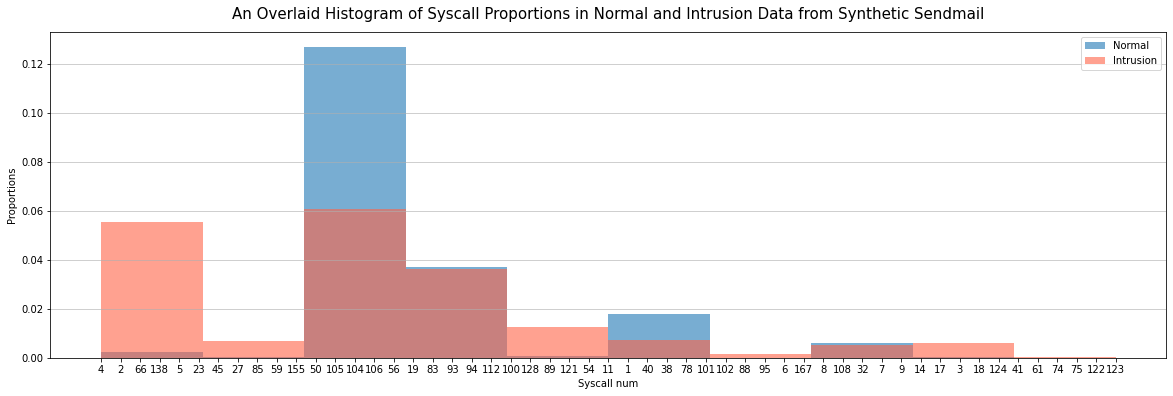

In [ ]:
# After Cleaning
plt.figure(figsize=(20,6))
plt.hist(normal[0], label='Normal', alpha=0.6, density=True)
plt.hist(intrusion[0], label='Intrusion', color='tomato', alpha=0.6, density=True)
plt.legend()
plt.ylabel('Proportions')
plt.xlabel('Syscall num')
plt.grid(axis='y', alpha=0.75)
#plt.xticks(np.arange(0,200,10))
plt.title('An Overlaid Histogram of Syscall Proportions in Normal and Intrusion Data from ' + DATA,y=1.02, fontsize=15)
plt.show()

**Labeling Sequences**

In [ ]:
# Intrusion sequences is labeled 1. Rename columns of the dataframe
intrusion['Label'] = 1
print(intrusion.head(5), '\n')

    0    1    2    3    4    5   6   7  ...  13  14  15  16  17  18  19 Label
0   4    2   66   66    4  138  66   5  ...   5   4   2  66  66   5   5     1
1   2   66   66    4  138   66   5  23  ...   4   2  66  66   5   5  85     1
2  66   66    4  138   66    5  23  45  ...   2  66  66   5   5  85   5     1
3  66    4  138   66    5   23  45   4  ...  66  66   5   5  85   5   5     1
4   4  138   66    5   23   45   4  27  ...  66   5   5  85   5   5   5     1

[5 rows x 21 columns] 



In [ ]:
# Normal sequences is labeled 0. Rename columns of the dataframe
normal['Label'] = 0
print(normal.head(5), '\n')

print('Normal len:',len(normal),'\nIntrusion len:', len(intrusion))

    0    1    2    3    4    5   6   7  ...  13  14  15  16  17  18  19 Label
0   4    2   66   66    4  138  66   5  ...   5   4   2  66  66   5   4     0
1   2   66   66    4  138   66   5  23  ...   4   2  66  66   5   4   2     0
2  66   66    4  138   66    5  23  45  ...   2  66  66   5   4   2  66     0
3  66    4  138   66    5   23  45   4  ...  66  66   5   4   2  66  66     0
4   4  138   66    5   23   45   4  27  ...  66   5   4   2  66  66   5     0

[5 rows x 21 columns] 

Normal len: 1799764 
Intrusion len: 6755


## **Partition Training and Testing dataset 70/30**

If there is not enough data from either class, bootstrap to generate more data and create a balanced sample

In [ ]:
# combine normal and intrusion data and split them into training and testing sets
df = normal.append(intrusion, ignore_index=True).astype(int)
print('Df sz:', df.shape)

# Spliting into training and testing
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df['Label'], test_size = 0.30, shuffle=True, random_state=24)

# Reset index of training and testing sets
x_train.reset_index(drop=True, inplace=True); y_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True);  y_test.reset_index(drop=True, inplace=True)

print('Train sz:',len(x_train), len(y_train))
intrusion_train = y_train.loc[y_train == 1]
normal_train = y_train.loc[y_train == 0]
print('Train set: Intrusion vs. Normal cases', len(y_train.iloc[intrusion_train] ), len(y_train.iloc[normal_train] ))

print('Test sz:', len(x_test), len(y_test))
intrusion_test = y_test.loc[y_test == 1]
normal_test = y_test.loc[y_test == 0]
print('Test set: Intrusion vs. Normal cases', len(y_test.iloc[intrusion_test] ), len(y_test.iloc[normal_test] ))

Df sz: (1806519, 21)
Train sz: 1264563 1264563
Train set: Intrusion vs. Normal cases 4760 1259803
Test sz: 541956 541956
Test set: Intrusion vs. Normal cases 1995 539961


In [ ]:
# Bootstrap training data

## Lived-name has more intrusion cases than normal cases (189 > 71) --> bootstrap normal cases only
x_train['Label'] = y_train

if len(intrusion_train) > len(normal_train):
  x_train = x_train.iloc[intrusion_train.index].append(x_train.iloc[normal_train.index].sample(n = len(intrusion_train), replace=True), ignore_index=True) #upsampled normal data and add to train set
else:
  x_train = x_train.iloc[normal_train.index].append(x_train.iloc[intrusion_train.index].sample(n = len(normal_train), replace=True), ignore_index=True) #upsampled intrusion data and add to train set

#x_train = x_train.append(x_train.sample(frac=1), ignore_index=True) # Bootstrap training data in case there is not enough data
x_train = x_train.sample(frac= SZ) # Shuffle data with a SZ proportion
x_train.reset_index(drop=True, inplace=True)
y_train = x_train['Label']
x_train.drop(columns='Label', inplace=True)
x_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2,66,66,4,138,66,5,23,45,4,27,66,5,4,2,66,66,5,5,85
1,78,19,4,93,94,5,112,19,93,100,50,128,89,121,5,5,4,50,27,2
2,104,106,19,105,104,104,106,78,112,105,104,104,106,105,108,112,19,19,105,104
3,6,18,2,95,5,5,5,5,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,105,104,104,106,19,105,104,104,106,78,112,105,104,104,106,105,108,112,19,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755877,105,104,104,106,78,112,105,104,104,106,105,108,112,19,19,105,104,104,106,78
755878,106,105,108,112,19,19,105,104,104,106,78,112,105,104,104,106,78,105,104,104
755879,104,106,105,104,104,106,56,17,123,122,4,18,50,27,105,108,112,19,19,105
755880,78,112,105,104,104,106,78,105,104,104,106,19,105,104,104,106,78,112,105,104


In [ ]:
y_train

0         1
1         1
2         0
3         1
4         0
         ..
755877    0
755878    0
755879    1
755880    0
755881    1
Name: Label, Length: 755882, dtype: int64

In [ ]:
x_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,106,105,108,112,19,19,105,104,104,106,78,112,105,104,104,106,78,105,104,104
1,104,104,106,78,105,104,104,106,19,105,104,104,106,78,112,105,104,104,106,105
2,104,106,78,105,104,104,106,19,105,104,104,106,78,112,105,104,104,106,105,108
3,106,78,112,105,104,104,106,105,108,112,19,19,105,104,104,106,78,112,105,104
4,104,106,78,112,105,104,104,106,105,108,112,19,19,105,104,104,106,78,112,105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541951,105,104,104,106,78,105,104,104,106,19,105,104,104,106,78,112,105,104,104,106
541952,106,78,112,105,104,104,106,78,105,104,104,106,19,105,104,104,106,78,112,105
541953,104,104,106,78,112,105,104,104,106,105,108,112,19,19,105,104,104,106,78,112
541954,106,78,105,104,104,106,19,105,104,104,106,78,112,105,104,104,106,105,108,112



# **Performance Measures**


1.   Function calc_false_positive: Calculates FPR
2.   Function print_performance: Formats printing performance metrics and ROC curve for each model
3.   Function color_confusion_matrix: prints out a heatmap of confusion matrix in blue color scale






In [ ]:
# This function calculate False Positive Rate given a confusion matrix
def calc_false_positive (cmatrix):
  specificity = cmatrix[0,0]/(cmatrix[0,0] + cmatrix[0,1])
  return 1-specificity

# This function prints performance metrics and ROC curve given the model name, true labels and predicted labels
def print_performance( model_name, true_labels, pred_labels):
  # rows are actual, columns are predicted
  cmatrix = confusion_matrix(true_labels, pred_labels)
  fpr = calc_false_positive(cmatrix)

  print('Confusion Matrix: \n',cmatrix)
  print('\nTesting Accuracy: %.2f'% metrics.accuracy_score(true_labels, pred_labels))
  print('Precision:%.2f'%  metrics.precision_score(true_labels, pred_labels))
  print('Recall: %.2f'% metrics.recall_score(true_labels, pred_labels))
  print('False Positive Rate: %.2f'% fpr)
  print('\nClassification report:', classification_report(true_labels, pred_labels), sep='\n')
  print('AUC: %.2f'% roc_auc_score(true_labels, pred_labels))

  false_positive_rate, recall, thresholds = roc_curve(true_labels, pred_labels)
  roc_auc = auc(false_positive_rate, recall)
  plt.figure()
  if CLEAN: clean_status='Clean '
  else: clean_status ='Overlapped and Duplicated '
  plt.title( model_name+' ROC Curve on '+ clean_status + DATA + ' with Seq Len of '+ str(SEQ_WINDOW))
  plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.2f' %roc_auc)
  plt.legend(loc='lower right')
  plt.plot([0,1], [0,1], 'r--')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.1])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  #plt.savefig(model_name+'-ROC.jpg')
  plt.show()

# Plot a heatmap of confusion matrix given the model name, a classifier model, testing data and the predicted label
def color_confusion_matrix( model_name, model, x_test, y_test, y_predicted):
  class_names = ['Normal', 'Intrusion']

  fig, ax = plt.subplots(figsize=(6, 6))
  plot_confusion_matrix(model, x_test, y_test, display_labels=class_names, 
                        values_format='d', ax = ax, cmap=plt.cm.Blues)
  plt.title('Confusion Matrix of ' + str(model_name))
  #plt.savefig(model_name+'-CM.jpg')
  plt.show()

  cmatrix = confusion_matrix(y_test, y_predicted)
  print(cmatrix)


# Save performance measure dict of each model to a file
def write_to_file (varname, model_name):
  clean_status = 'clean' if CLEAN else 'unclean'
  filename = DATA +'-'+ str(SEQ_WINDOW) +'-'+ clean_status + ".txt"
  file = open(filename, "a")
  str_dictionary = repr(varname)
  file.write("{}_test = ".format(model_name) + str_dictionary + "\n")
  file.close()


# **K-means**

Confusion Matrix: 
 [[528030  11931]
 [   951   1044]]

Testing Accuracy: 0.98
Precision:0.08
Recall: 0.52
False Positive Rate: 0.02

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    539961
           1       0.08      0.52      0.14      1995

    accuracy                           0.98    541956
   macro avg       0.54      0.75      0.56    541956
weighted avg       0.99      0.98      0.98    541956

AUC: 0.75


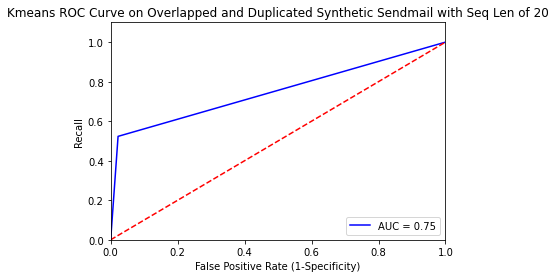

Number of iterations before converging: 5
Train AUC: 0.746 vs Test AUC: 0.751


In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score

# Choose K cluster = 2
kmeans = KMeans(n_clusters=2)
# Fit Kmeans to the training set
kmeans.fit(x_train)


# Recording TPR and FPR to plot TRAINING ROC curves
y_pred = kmeans.predict(x_train)
KM_train = {}
KM_train['fpr'], KM_train['tpr'], thresh = roc_curve(y_train, y_pred)
KM_train['auc'] = roc_auc_score(y_train, y_pred)

## TESTING K-MEANS
y_predicted = kmeans.predict(x_test)

print_performance('Kmeans',y_test, y_predicted)

# Number of iterations before converging
print('Number of iterations before converging:', kmeans.n_iter_)


# Recording TPR and FPR for the TESTING ROC curves
KM_test = {}
KM_test['fpr'], KM_test['tpr'], thresh = roc_curve(y_test, y_predicted)
KM_test['auc'] = roc_auc_score(y_test, y_predicted)


print('Train AUC: %.3f vs Test AUC: %.3f' %(KM_train['auc'], KM_test['auc']))

In [ ]:
write_to_file(KM_test, 'KM')

# **Logistic Regression**

Confusion Matrix: 
 [[519827  20134]
 [   496   1499]]

Testing Accuracy: 0.96
Precision:0.07
Recall: 0.75
False Positive Rate: 0.04

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    539961
           1       0.07      0.75      0.13      1995

    accuracy                           0.96    541956
   macro avg       0.53      0.86      0.55    541956
weighted avg       1.00      0.96      0.98    541956

AUC: 0.86


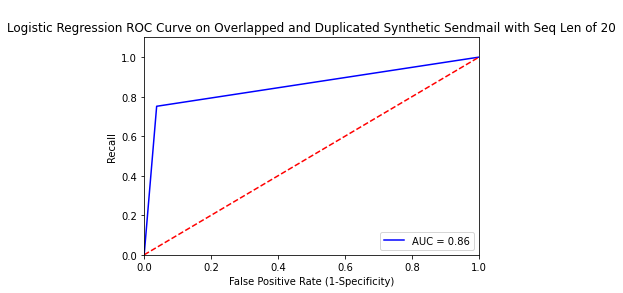

Train AUC: 0.860 vs Test AUC: 0.857


In [ ]:
from sklearn.linear_model import LogisticRegression

# Fit the model on the training set
lgModel = LogisticRegression().fit(x_train, y_train)
y_pred = lgModel.predict(x_train)

# Recording TPR and FPR for the TESTING ROC curves
LR_train = {}
LR_train['fpr'], LR_train['tpr'], thresh = roc_curve(y_train, y_pred)
LR_train['auc'] = roc_auc_score(y_train, y_pred)


## TESTING Logistic Regression
y_predicted = lgModel.predict(x_test)

# Evaluating Performance on Testing data
print_performance('\nLogistic Regression', y_test, y_predicted)

# Recording TPR and FPR for the multi-ROC curves
LR_test = {}
LR_test['fpr'], LR_test['tpr'], thresh = roc_curve(y_test, y_predicted)
LR_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(LR_train['auc'], LR_test['auc']))

In [ ]:
# Save performance to text file
write_to_file(LR_test, 'LR')

# **SVM**

This model uses a Polynomial kernel, and the rest of the parameters are as default






In [ ]:
if len(x_train) > 500000: 
  svm_sz = 0.1  
elif len(x_train) > 100000:
  svm_sz = 0.2
else:
  svm_sz = 1

svm_sz

0.1

In [ ]:

train_data = x_train.copy(deep=True) # create a deep copy of x_train, so any modification to train_data won't affect x_train
train_data['Label'] = y_train
train_data = train_data.groupby('Label').sample(frac = svm_sz)
train_data.reset_index(drop=True, inplace= True)
#train_data
svm_x_train = train_data.drop(columns='Label')
svm_y_train = train_data['Label']
svm_x_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,19,105,104,104,106,78,112,105,104,104,106,78,105,104,104,106,19,105,104,104
1,105,104,104,106,78,112,105,104,104,106,78,105,104,104,106,19,105,104,104,106
2,106,19,105,104,104,106,78,112,105,104,104,106,105,108,112,19,19,105,104,104
3,105,104,104,106,105,108,112,19,19,105,104,104,106,78,112,105,104,104,106,78
4,106,105,108,112,19,19,105,104,104,106,78,112,105,104,104,106,78,105,104,104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75584,128,85,89,121,5,5,4,50,27,2,19,4,93,94,5,112,19,93,100,50
75585,14,50,27,3,5,9,124,1,112,4,5,5,5,5,5,5,5,-1,-1,-1
75586,104,104,106,78,112,105,104,104,106,78,105,104,104,106,19,105,104,104,106,78
75587,112,19,19,105,104,104,106,78,112,105,104,104,106,78,2,105,104,104,106,19



****Polynomial kernel model: 
Confusion Matrix: 
 [[511470  28491]
 [   270   1725]]

Testing Accuracy: 0.95
Precision:0.06
Recall: 0.86
False Positive Rate: 0.05

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    539961
           1       0.06      0.86      0.11      1995

    accuracy                           0.95    541956
   macro avg       0.53      0.91      0.54    541956
weighted avg       1.00      0.95      0.97    541956

AUC: 0.91


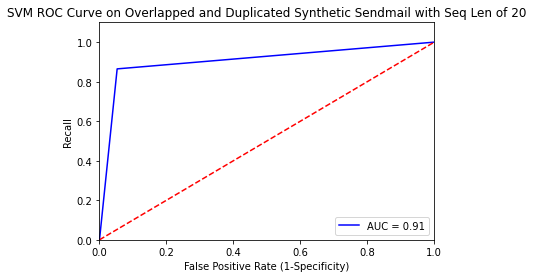

Train AUC: 0.915 vs Test AUC: 0.906


In [ ]:
from sklearn import svm

#### Create a SVM classifier using polynomial Kernel
print('\n****Polynomial kernel model: ')
svm_model = svm.SVC(kernel = 'poly')

#Train the  & Get accuracy from training
svm_model.fit(svm_x_train, svm_y_train)
y_pred = svm_model.predict(svm_x_train)

# Recording TPR and FPR for plotting TRAINING ROC curves
SVM_train = {}
SVM_train['fpr'], SVM_train['tpr'], thresh = roc_curve(svm_y_train, y_pred)
SVM_train['auc'] = roc_auc_score(svm_y_train, y_pred)


# Test the model w testing data
y_predicted = svm_model.predict(x_test)

# Evaluate the model 
print_performance('SVM', y_test, y_predicted)

# Recording TPR and FPR for TESTING-ROC curves
SVM_test = {}
SVM_test['fpr'], SVM_test['tpr'], thresh = roc_curve(y_test, y_predicted)
SVM_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(SVM_train['auc'], SVM_test['auc']))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


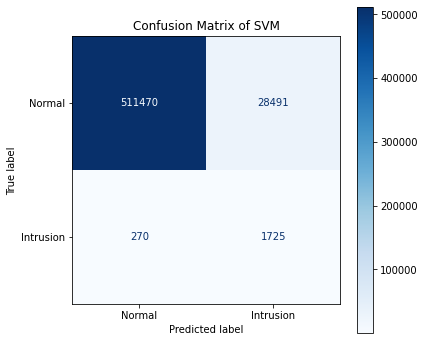

[[511470  28491]
 [   270   1725]]


In [ ]:
# Plot a heatmap confusion matrix
color_confusion_matrix('SVM', svm_model, x_test, y_test, y_predicted)

In [ ]:
# Save performance to text file
write_to_file(SVM_test, 'SVM')

# **Neural Net**

This model contains 3 layers: input layer of 6 nodes, a fully connected layer of 6 nodes and an output layer of 2 nodes

In [ ]:
# Scale syscall number to between 0 and 1
# The maximum syscall number in UNM data is 181
max_syscall = 181
x_train_nn = x_train/max_syscall
x_test_nn = x_test/max_syscall

In [ ]:
import tensorflow as tf
from tensorflow import keras
INPUT_SZ = len(x_train.columns)
nn_model = keras.Sequential([
    keras.layers.Input(shape = (INPUT_SZ,)),           # model expect input to be a vector of 6 numbers
    keras.layers.Dense(INPUT_SZ, activation = 'relu'), 
    keras.layers.Dense(2, activation = 'sigmoid')
])

nn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fit the model to training set
history = nn_model.fit(x_train_nn, y_train, epochs=10, batch_size= 32, verbose=1)  

Epoch 1/10
23622/23622 [==============================] - 32s 1ms/step - loss: 0.3403 - accuracy: 0.8869
Epoch 2/10
23622/23622 [==============================] - 31s 1ms/step - loss: 0.3102 - accuracy: 0.9003
Epoch 3/10
23622/23622 [==============================] - 31s 1ms/step - loss: 0.3046 - accuracy: 0.9028
Epoch 4/10
 2516/23622 [==>...........................] - ETA: 28s - loss: 0.3012 - accuracy: 0.9046

In [ ]:
# Get predicted Training labels
y_pred = np.argmax(nn_model.predict(x_train_nn), axis=-1)

# Recording TPR and FPR for the TRAINING ROC curves
NN_train = {}
NN_train['fpr'], NN_train['tpr'], thresh = roc_curve(y_train, y_pred)
NN_train['auc'] = roc_auc_score(y_train, y_pred)
#print_performance(y_train, y_predicted)

In [ ]:
# Get the loss and accuracy on testing set
test_loss, test_acc = nn_model.evaluate(x_test_nn,  y_test, verbose=1) 
y_predicted = np.argmax(nn_model.predict(x_test_nn), axis=-1)


print('Test accuracy:', test_acc,' Test loss:', test_loss)
print_performance('Neural Network', y_test, y_predicted)

# Recording TPR and FPR for the TESTING-ROC curves
NN_test = {}
NN_test['fpr'], NN_test['tpr'], thresh = roc_curve(y_test, y_predicted)
NN_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(NN_train['auc'], NN_test['auc']))

In [ ]:
nn_model.summary()

#history.history

In [ ]:
# Save performance to text file
write_to_file(NN_test, 'NN')

# **Decision Tree**

This model uses GINI criterion to split the data and requires at least 10 observations to split and 5 observations in the leaf.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Create and Train DecTree model
decTree = DecisionTreeClassifier(criterion='gini', min_samples_split=10,min_samples_leaf=5,max_features='auto')
decTree = decTree.fit(x_train, y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = decTree.predict(x_train)
DT_train = {}
DT_train['fpr'], DT_train['tpr'], thresh = roc_curve(y_train, y_pred)
DT_train['auc'] = roc_auc_score(y_train, y_pred)

# Predict testing data
y_predicted = decTree.predict(x_test)

# Print performance measures
print_performance('Decision Tree', y_test, y_predicted)

# Color Confusion Matrix
color_confusion_matrix('Decision Tree', decTree, x_test, y_test, y_predicted)

# Recording TPR and FPR for TESTING-ROC curves
DT_test = {}
DT_test['fpr'], DT_test['tpr'], thresh = roc_curve(y_test, y_predicted)
DT_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(DT_train['auc'], DT_test['auc']))

In [ ]:
# Save performance to text file
write_to_file( DT_test, 'DT')

# **Random Forest**

This model has no max depth and allows bootstrapping observations during training. It uses GINI criterion to split and requires a minimum of 10 observations to split and the leaf node must have above 5 observations.


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Build model
randomForest = RandomForestClassifier(max_depth=None, min_samples_split=10, min_samples_leaf=5, 
                                      max_features='auto', bootstrap=True,verbose=0, criterion='gini')
# Train the model with training set
randomForest.fit(x_train, y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = randomForest.predict(x_train)
RF_train = {}
RF_train['fpr'], RF_train['tpr'], thresh = roc_curve(y_train, y_pred)
RF_train['auc'] = roc_auc_score(y_train, y_pred)

# Predict the labels for testing set
y_predicted = randomForest.predict(x_test)

# Print performance measures
print_performance('Random Forest', y_test, y_predicted)

# Color Confusion Matrix
color_confusion_matrix('Random Forest', randomForest, x_test, y_test, y_predicted)

# Recording TPR and FPR for the multi-ROC curves
RF_test = {}
RF_test['fpr'], RF_test['tpr'], thresh = roc_curve(y_test, y_predicted)
RF_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(RF_train['auc'], RF_test['auc']))

In [ ]:
# Save performance to text file
write_to_file( RF_test, 'RF')

# **KNN**

This model classifies each observation based on 3 nearest neighbors with uniform weight.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Creat and Train KNN model
KNN = KNeighborsClassifier(n_neighbors=5, weights='uniform')
KNN.fit(x_train, y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = KNN.predict(x_train)
KNN_train = {}
KNN_train['fpr'], KNN_train['tpr'], thresh = roc_curve(y_train, y_pred)
KNN_train['auc'] = roc_auc_score(y_train, y_pred)

# Predict testing data
y_predicted = KNN.predict(x_test)

# Print performance measures
print_performance('KNN', y_test, y_predicted)

# Color Confusion Matrix
color_confusion_matrix('KNN', KNN, x_test, y_test, y_predicted)

# Recording TPR and FPR for TESTING-ROC curves
KNN_test = {}
KNN_test['fpr'], KNN_test['tpr'], thresh = roc_curve(y_test, y_predicted)
KNN_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(KNN_train['auc'], KNN_test['auc']))

In [ ]:
# Save performance to text file
write_to_file( KNN_test, 'KNN')

# **Naive Bayes**

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Create a Gaussian Naive Bayes classifier and train with training set
NaiveBayes = GaussianNB()
NaiveBayes.fit(x_train, y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = NaiveBayes.predict(x_train)
NB_train = {}
NB_train['fpr'], NB_train['tpr'], thresh = roc_curve(y_train, y_pred)
NB_train['auc'] = roc_auc_score(y_train, y_pred)

# Predict testing data
y_predicted = NaiveBayes.predict(x_test)

# Print performance measures
print_performance('Naive Bayes', y_test, y_predicted)

# Recording TPR and FPR for the TESTING-ROC curves
NB_test = {}
NB_test['fpr'], NB_test['tpr'], thresh = roc_curve(y_test, y_predicted)
NB_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(NB_train['auc'], NB_test['auc']))

In [ ]:
# Save performance to text file
write_to_file(NB_test, 'NB')

# **End**

In [ ]:
# Graphing overlaid ROC curves, where each one represents a model AUC score
def graph_multi_ROC (DATA, SEQ_LEN, CLEAN ):
  # Set color for each model
  colors = {'KM': 'lightcoral','LR': 'darkorange', 'SVM':'lime', 'NB': 'steelblue',
            'NN': 'purple','DT': 'magenta','RF': 'deeppink','KNN': 'darkturquoise',
            'BERT': 'darkred', 'GPT': 'blue'}
  # Set marker for each model          
  markers = {'KM':'1--','LR': 'v--', 'SVM': '^--', 'NN': '*--', 'DT': 'o--', 'RF': '+--', 'KNN': '.--', 'NB': 'x--', 'BERT':'<--', 'GPT': '>--'}
  
  plt.figure(figsize=(9,6))

  plt.plot(KM_test.get('fpr'), KM_test.get('tpr'), markers.get('KM'), color=colors.get('KM'),  label="KM - AUC=" + str( round(KM_test.get('auc'), 3) ) )   
  plt.plot(LR_test.get('fpr'), LR_test.get('tpr'), markers.get('LR'), color=colors.get('LR'),  label="LR - AUC=" + str( round(LR_test.get('auc'),3) ) )
  plt.plot(SVM_test.get('fpr'),SVM_test.get('tpr'),markers.get('SVM'),color=colors.get('SVM'), label="SVM - AUC="+ str( round(SVM_test.get('auc'), 3) ) )
  plt.plot(NN_test.get('fpr'), NN_test.get('tpr'), markers.get('NN'), color=colors.get('NN'),  label="NN - AUC=" + str( round(NN_test.get('auc'), 3) ) )
  plt.plot(DT_test.get('fpr'), DT_test.get('tpr'), markers.get('DT'), color=colors.get('DT'),  label="DT - AUC=" + str( round(DT_test.get('auc'), 3) ) )
  plt.plot(RF_test.get('fpr'), RF_test.get('tpr'), markers.get('RF'), color=colors.get('RF'),  label="RF - AUC=" + str( round(RF_test.get('auc'), 3) ) )
  plt.plot(KNN_test.get('fpr'),KNN_test.get('tpr'),markers.get('KNN'),color=colors.get('KNN'), label="KNN - AUC="+ str( round(KNN_test.get('auc'), 3) ) )
  plt.plot(NB_test.get('fpr'), NB_test.get('tpr'), markers.get('NB'), color=colors.get('NB'),  label="NB - AUC=" + str( round(NB_test.get('auc'), 3) ) )
  try:
    plt.plot(BERT_test.get('fpr'),BERT_test.get('tpr'), markers.get('BERT'), color=colors.get('BERT'),  label="BERT - AUC="+ str(BERT_test.get('auc').round(3)))
    plt.plot(GPT_test.get('fpr'),GPT_test.get('tpr'), markers.get('GPT'), color=colors.get('GPT'),  label="GPT-2 - AUC="+ str(GPT_test.get('auc').round(3)))
  except NameError:
    print('\nBERT_test and GPT_test do not exist\n')

  plt.plot([0,1], [0,1], 'k--', label='Random Chances')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.02])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  plt.legend(loc='lower right') 
  plt.title( 'Testing ROCs %s on %s with seq len of %d' % (CLEAN, DATA, SEQ_LEN) )
  #plt.savefig(DATA_I+'-'+train_or_test+'.jpg', dpi = 80)
  plt.show()


# Func load_dict loads the dictionary contents extracted from the text file to a given variable name (stored in varname str)
# Output is a global dict variable 
# Input format:
## varname: a string of variable name
## dictvar: a dict containing the dictionary contents extracted from the text file
def load_dict(varname, dictvar):
  exec('%s = {}' %(varname), globals() )
  for key, value in dictvar.items():
    #print(key,":", value)
    exec('%s[%s] = %s' % (varname, key, value), globals())

# Func localFile extract the contents of each dictionary variables and load them into a dictionary
# Output: All the dictionaries from the text file will be loaded to the program
#  Input format: a text file containing multiple dictionaries, where each dict has this format:
## KM_test = {'fpr': array([0.        , 0.86136255, 1.        ]), 'tpr': array([0.        , 0.49007655, 1.        ]), 'auc': 0.31435699935689737}
## This function reads in each line, process the string and load it as a dict variable
## In the end, this function loads global variables based on each line of text
def load_dict_from_text (localFile):
  with open(localFile) as infile_object : 
    lines = infile_object.read().splitlines()    # Open and read each line
    measures = {}                                # stores elements of a dict
  for line in lines: 
    words = line.strip("\n ").split(' = ')     # remove whitespace and split str to get var name. words[0] contains var name, words[1] contains the phrase that goes after '='
    values = words[1].strip(" {} ").split('), ') # remove the whitespace and '{}', then split the second part of words to get each element in dict
    # iterate through each key-value pairelement and process them to get specific key-value pair
    for v in values:  
      elements = v.split(': ')                   # split key value pair by ':'. elements[0] is key, elements[1] is value
      elements[1] = elements[1].strip('array(')  # remove 'array(' from the value
      #print(elements[0]) print(elements[1])
      measures[ elements[0] ] = elements[1]      # save the key-value pairs found in a line into measures dict

    load_dict(words[0], measures)                # load the content of measures dict into the variable name stored in words[0]
        


In [ ]:
       
#fileName = 'MIT Live Lpr-pm.txt'
#load_dict_from_text(fileName)

In [ ]:
clean_status = 'clean' if CLEAN else 'unclean'
graph_multi_ROC(DATA, SEQ_WINDOW, clean_status)

## **Note**

Synthetic Sendmail dataset contains some sequences with only 6 system calls. Therefore we padded on the right with -1 on these small sequences, so that the sequence length can be 15.
After cleaning, there are 2021 unique normal sequences, while there are 423 unique intrusion sequences. This dataset is imbalanced. 

BERT and GPT significantly outperform the rest of the models with AUC above 0.95, while the others perform poorly on this dataset (AUC around 0.5)


